<a href="https://colab.research.google.com/github/Merijn68/rl-alm/blob/main/notebooks/Train%20PPO%20model%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Train PPO RL model

The Proximal Policy Optimization algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

The main idea is that after an update, the new policy should be not too far from the old policy. For that, ppo uses clipping to avoid too large update.

Original paper: https://arxiv.org/abs/1707.06347

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 13 17:39:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!git clone https://github.com/Merijn68/rl-alm.git

Cloning into 'rl-alm'...
remote: Enumerating objects: 783, done.
remote: Counting objects: 100% (783/783), done.
remote: Compressing objects: 100% (443/443), done.
remote: Total 783 (delta 414), reused 664 (delta 332), pack-reused 0
Receiving objects: 100% (783/783), 19.11 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (414/414), done.


In [5]:
%cd /content/rl-alm/

/content/rl-alm


In [6]:
!pip install stable_baselines3
!pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.4 MB/s eta 0:00:00


In [7]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard
import os
import sys
from pathlib import Path
import pandas as pd
from stable_baselines3 import PPO

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
print(f"Current dirt: {current_dir}")
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
sys.path.append(os.path.join(project_root, 'src'))
print(f"Project root: {project_root}")

# # flake8: noqa  # Disable Flake8 for the following block
import gymnasium as gym

from src.models.bank_env import BankEnv
from src.visualization import visualize
import src.models.train as train
from src.tests import test_bankmodel_a2c_train as tests
from src.data.definitions import MODEL_PATH, TENSORBOARD_LOGS, DATA_MODEL_PATH
from src.models.evaluate import evaluate_policy

Current dirt: /content/rl-alm
Project root: /content/rl-alm


In [8]:
# Change Path settings to output results to gdrive

MODEL_PATH = Path('/content/gdrive/MyDrive/rl-alm/models')
DATA_MODEL_PATH = Path('/content/gdrive/MyDrive/rl-alm/data/model')
FIGURES_PATH = Path('/content/gdrive/MyDrive/rl-alm/reports/figures')
NOTEBOOK_PATH = Path('/content/gdrive/MyDrive/rl-alm/notebooks')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### First test - just take a random walk in the environment.

Each episode consists of 60 months. Each timestep interest rates and swap rates are simulated and the bank enters into new mortgages.  
Each month the actor needs to decide on the funding strategy to fund the bank.

In [9]:
env_id = "bank-v3"
gym.register(id=env_id, entry_point=BankEnv, max_episode_steps=60)


In [10]:
# Random walk in the environment
tests.random_walk(env_id)

2023-11-13 17:40:10.656 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-11-13 17:40:11.325 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))
steps: 60, score: -11584


Define the model. For the initial model we use the PPO model.

In [11]:
# from stable_baselines3.common.vec_env import DummyVecEnv

env = gym.make(env_id, render_mode="human")
# env = DummyVecEnv([lambda: env])

# Define a Lineair Learning Rate Scheduler
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        """Progress will decrease from 1 (beginning) to 0."""
        return progress_remaining * initial_value

    return func

initial_lr = 0.001
n_steps = 60
model_name = 'PPO'
ent_coef= 0.001
gamma = 0.75

model = PPO(
        "MultiInputPolicy",
        env,
        tensorboard_log=TENSORBOARD_LOGS,
        verbose=1,
        learning_rate=linear_schedule(initial_lr),
        gamma = gamma,
        ent_coef = ent_coef,
        use_sde = False, # Use generalized State Dependent Exploration (gSDE) instead of action noise exploration,
        device='cuda'
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-11-13 17:40:12.537 | INFO     | src.data.dataset:read_data:45 - reading interest data from ESW.
2023-11-13 17:40:12.818 | INFO     | src.data.dataset:read_data:45 - reading zerocurve data from ESW.


Interest period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))
Zerocurve period:  (Timestamp('2010-06-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


##### Train the model in the environment and save it

In [12]:
steps = 600_000

model, mean, episode_iqr, episode_cvar, episode_rewards = train.train( model, env, total_timesteps=steps, conf_level=0.95, tb_log_name= TENSORBOARD_LOGS)
modelpath = Path(
        MODEL_PATH,
        model_name + "_" + str(steps) + ".zip",
    )
model.save(modelpath)
pd.DataFrame(episode_rewards).to_csv(Path(DATA_MODEL_PATH, model_name + "_" + str(steps) + ".csv"))

# episode_rewards = env.unwrapped.episode_rewards

Logging to /content/rl-alm/tensorboard_logs_1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.reset_episode_statistics to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reset_episode_statistics` for environment variables or `env.get_wrapper_attr('reset_episode_statistics')` that will search the reminding wrappers.
  logger.warn(


Streaming output truncated to the last 5000 lines.
|    loss                 | 226         |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.00395    |
|    std                  | 0.836       |
|    value_loss           | 5.58e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 60          |
|    ep_rew_mean          | 825         |
| time/                   |             |
|    fps                  | 316         |
|    iterations           | 67          |
|    time_elapsed         | 433         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.009363879 |
|    clip_fraction        | 0.0819      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.89       |
|    explained_variance   | 0.211       |
|    learning_rate        | 0.000775    |
|    loss                

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.episode_rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.episode_rewards` for environment variables or `env.get_wrapper_attr('episode_rewards')` that will search the reminding wrappers.
  logger.warn(


Model name: PPO, Steps: 600000, Mean: 787.0617938206179, IQR: 258.0, CVaR: -4782.526315789473


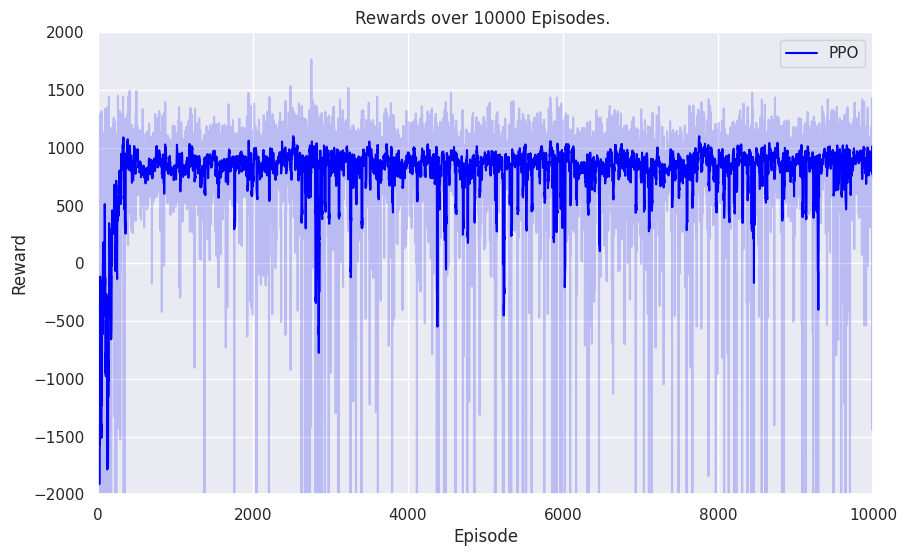

In [13]:
print(f"Model name: {model_name}, Steps: {steps}, Mean: {mean}, IQR: {episode_iqr}, CVaR: {episode_cvar}")
visualize.plot_rewards(episode_rewards, interpolate_line=False, rolling_line= True, ylim=(-2000,2000),color = "Blue",
                       label = model_name, title = f"Rewards over {int(steps/60)} Episodes. ",
                       name = f"{model_name}_{steps}_rewards",
                       figurepath = FIGURES_PATH )

Showing the results of the trained model

In [14]:
print(model.policy)

MultiInputActorCriticPolicy(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (pi_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_dim=-1)
      (features): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (vf_features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (liquidity): Flatten(start_dim=1, end_dim=-1)
      (cashflows): Flatten(start_dim=1, end_dim=-1)
      (swap_rates): Flatten(start_dim=1, end_dim=-1)
      (bank_rates): Flatten(start_dim=1, end_di

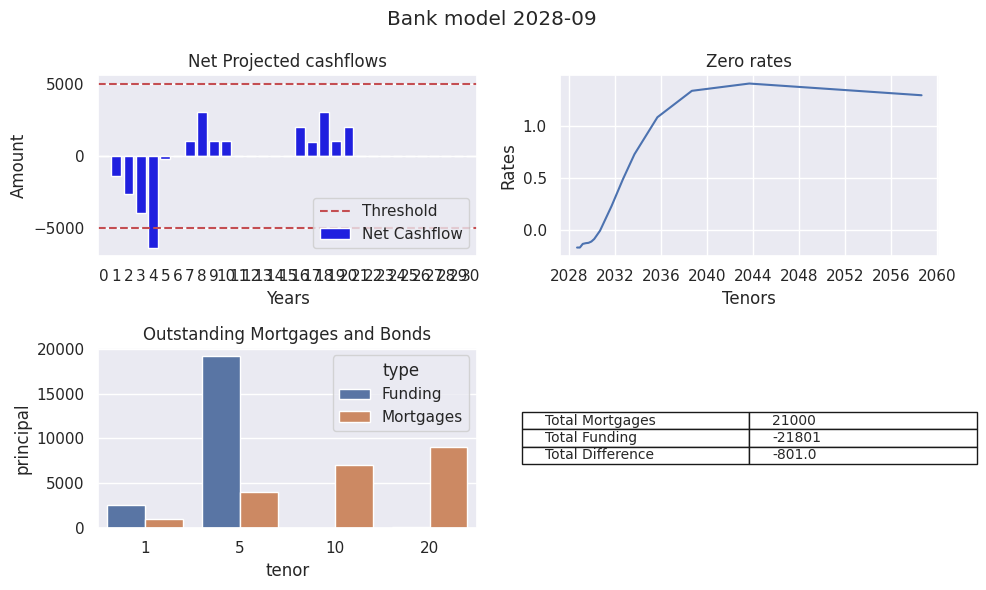

final score:  -610


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

,timestep,reward,risk_penalty,liquidity_penalty,liquidity,nii,income,funding_cost,total_funding,total_mortgages
0,1,-2,0,0,1076.325981,-2,0.000000,-2.323763,-1076,0
1,2,-2,0,0,1076.325981,-2,0.000000,-2.323763,-1076,0
2,3,0,0,0,1033.493858,0,3.764573,-4.081129,-2032,1000
3,4,0,0,0,1033.493858,0,3.764573,-4.081129,-2032,1000
4,5,2,0,0,33.493858,2,6.730972,-4.081129,-2032,2000
5,6,2,0,0,46.863716,2,6.730972,-4.098593,-2045,2000
6,7,2,0,0,46.863716,2,6.730972,-4.098593,-2045,2000
7,8,2,0,0,46.863716,2,6.730972,-4.098593,-2045,2000
8,9,2,0,0,458.173622,2,6.730972,-4.697375,-2456,2000
9,10,1,0,0,647.976341,1,6.730972,-4.892879,-2645,2000


In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def show_model(env, model) -> int:
    """Show the model in the environment"""
    # env.set_render_output(modelpath.stem)
    obs, info = env.reset()
    score = 0
    terminated = False
    truncated = False
    # env.set_render_output('A2C')

    while not terminated and not truncated:
        action, _state = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        score = score + reward
        # env.render()
        df = env.list_model()
    env.plot()
    env.close()
    return score, df

score, df = show_model(env, model)

warnings.filterwarnings("default")

print ('final score: ', score)
df.head(60)

In [16]:
mean_reward, irq, es, rewards = evaluate_policy(model, env, n_eval_episodes=500)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(f"number of episodes = {len(rewards)}, mean_reward={mean_reward:.2f} Expected Shortfall={es:.2f} Interquartile Range={irq:.2f}")

number of episodes = 500, mean_reward=796.50 Expected Shortfall=-5451.00 Interquartile Range=234.25


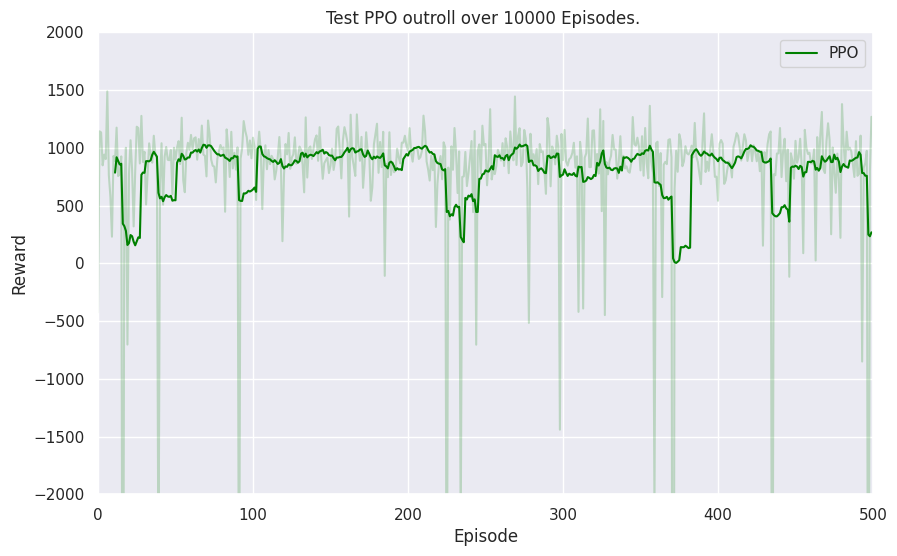

In [18]:
visualize.plot_rewards(rewards, interpolate_line=False, rolling_line=True, ylim=(-2000,2000), color = 'Green',
                       label = model_name,
                       title = f"Test {model_name} outroll over {int(steps/60)} Episodes. ")

It would be great if we can store a local copy of the notebook after execution so I can easily look back at the performed actions...

In [19]:
from google.colab import runtime
runtime.unassign()

<ipython-input-19-44ec248844a9>:2: ResourceWarning: unclosed <socket.socket fd=90, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.12', 55556), raddr=('172.28.0.1', 8011)>
  runtime.unassign()
